# Flow Over An AirFoil
### Nishchay N
### PES University

Importing Required Libraries

In [51]:
import numpy as np
import matplotlib.pyplot as plt
np.seterr(divide ='ignore',invalid ='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

Defining Required Functions

In [52]:
# Descretization or Meshing
# Boundary Element Method

def geometry(x_list,y_list,seg_list):
    # total No.of Segments
    Ns = np.sum(seg_list)
    
    # Total No.of Segments With End Points
    Np = int(Ns+1)
    
    # Length of Boundary Elements
    lb  = np.sqrt((x_list[1:]-x_list[:-1])**2+(y_list[1:]-y_list[:-1])**2)
    
    #Total no of segements before the decretization
    seg_num = np.zeros(seg_list.size)
    for i in range(1,seg_list.size):
        seg_num[i] = seg_num[i-1]+seg_list[i-1]
        
    # Initial Array
    x,y = [np.zeros(Np) for i in range(2)]
    
    x[0] = x[-1] = x_list[0]; y[0] = y[-1] = y_list[0]
    
    # Each and Every Boundary Element Values
    for i in range (seg_list.size):
        x[int(seg_num[i]):int(seg_num[i]+seg_list[i]+1)] = np.linspace(int(x_list[i]),int(x_list[i+1]),int(seg_list[i]+1))
        y[int(seg_num[i]):int(seg_num[i]+seg_list[i]+1)] = np.linspace(int(y_list[i]),int(y_list[i+1]),int(seg_list[i]+1))
        
    #list odf the midpoints element
    xm = 0.5*(x[1:]+x[:-1])
    ym = 0.5*(y[1:]+y[:-1])
    
    # List of Boundary Values
    xms,yms = [[0]*seg_list.size for i in range(2)]
    
    for i in range(seg_list.size):
        xms[i] = np.array(xm[int(seg_num[i]):int(seg_num[i]+seg_list[i])])
        yms[i] = np.array(ym[int(seg_num[i]):int(seg_num[i]+seg_list[i])])
    
    # Length of Each Segment After Meshing
    l = np.sqrt((x[1:]-x[:-1])**2+(y[1:]-y[:-1])**2)
    
    #Normal vectors
    ny = (x[:-1] - x[1:])/l
    nx = (y[1:] - y[:-1])/l
    
    return x,y,xm,ym,xms,yms,nx,ny,l,Ns,seg_num,lb
# Setting the Boundary Conditions for each and Every Segments of the Boundary
def setBC(bct,bcv,seg_list,seg_num):
    BCT,BCV = [np.zeros(Ns) for i in range(2)]
    for i in range(seg_list.size):
        BCT[int(seg_num[i]):int(seg_num[i]+seg_list[i])] = bct[i]
        BCV[int(seg_num[i]):int(seg_num[i]+seg_list[i])] = bcv[i]
        
    return BCT,BCV
#Calculateing F1 and F2
def F1F2(x0,y0,x,y,l,nx,ny):    
    k = int(Ns)  # No.of Segments
    s = x0.size  # N.of Points

    A, B, E, F1, F2 = [np.zeros((k,s)) for i in range(5)]
    k = np.arange(k)
    s = np.arange(s)    
    K, S = np.meshgrid(k,s)
    
    A[K,:] = np.square(l[K]).T
    B[K,S] = 2*l[K]*(-(x[K]-x0[S])*ny[K] + (y[K]-y0[S])*nx[K])
    E[K,S] = (x[K]-x0[S])**2 + (y[K]-y0[S])**2

    M = 4*A*E - B**2
    D = 0.5*B/A
    
    zero = 1e-10 # Small Number to Prevent Error
    
    # Indices w.r.t Condition
    I,J = np.where(M<zero)
    i,j = np.where(M>zero)

    # For M = 0
    F1[I,J] = 0.5*l[I]*(np.log(l[I]) \
                          + (1 + D[I,J])*np.log(np.abs(1 + D[I,J]) + zero) \
                          - D[I,J]*np.log(np.abs(D[I,J] + zero)) - 1)/np.pi

    H = np.arctan((2*A[i,j]+B[i,j])/np.sqrt(M[i,j])) - np.arctan(B[i,j]/np.sqrt(M[i,j]))
    F1[i,j] = 0.25*l[i]*(2*(np.log(l[i]) - 1) \
                           - D[i,j]*np.log(np.abs(E[i,j]/A[i,j])) \
                           + (1 + D[i,j])*np.log(np.abs(1 + 2*D[i,j] + E[i,j]/A[i,j])) \
                           + H*np.sqrt(M[i,j])/A[i,j])/np.pi
    
    # For M > 0
    F2[i,j] = l[i]*(nx[i]*(x[i] - x0[j]) + ny[i]*(y[i] - y0[j]))*H/np.sqrt(M[i,j])/np.pi

    return F1.T, F2.T

#Programming phi and p
def pqBC(F1,F2,BCT,BCV):
    Ns = BCT.size
    F2x = F2 - 0.5*np.eye(Ns)
    a,b = [np.zeros((Ns,Ns)) for i in range(2)]

    # phi to be known and d(phi)/dn is unknown
    col_p = np.where(BCT==0)
    a[:,col_p] = -F1[:,col_p]
    b[:,col_p] = -F2x[:,col_p]

    #d(phi/dn) to be known and phi is unknown
    col_q = np.where(BCT==1)
    a[:,col_q] = F2x[:,col_q]
    b[:,col_q] = F1[:,col_q]
    
    BCV2 = np.linalg.solve(a,np.dot(b,BCV))

    p = BCV2.copy()
    q = BCV2.copy()

    p[col_p] = BCV[col_p]  # Phi
    q[col_q] = BCV[col_q]  # d(Phi)/dn

    return p, q

Defining Required Inputs

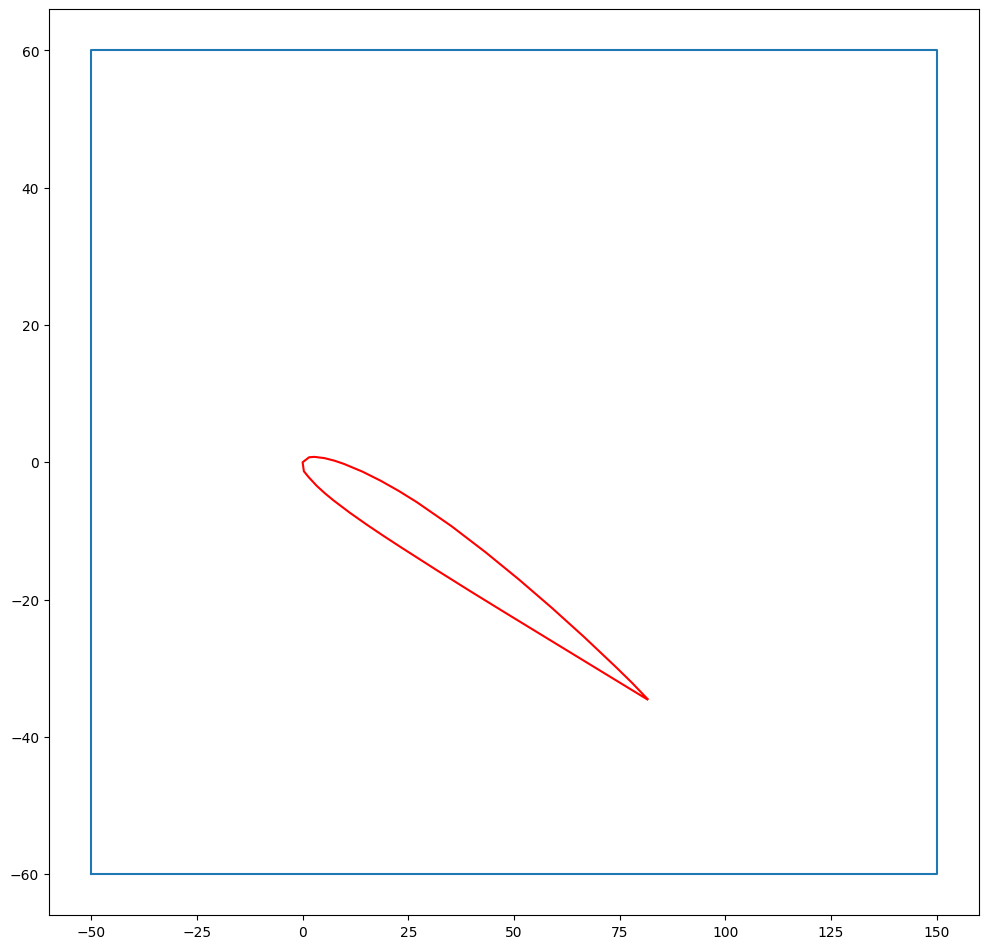

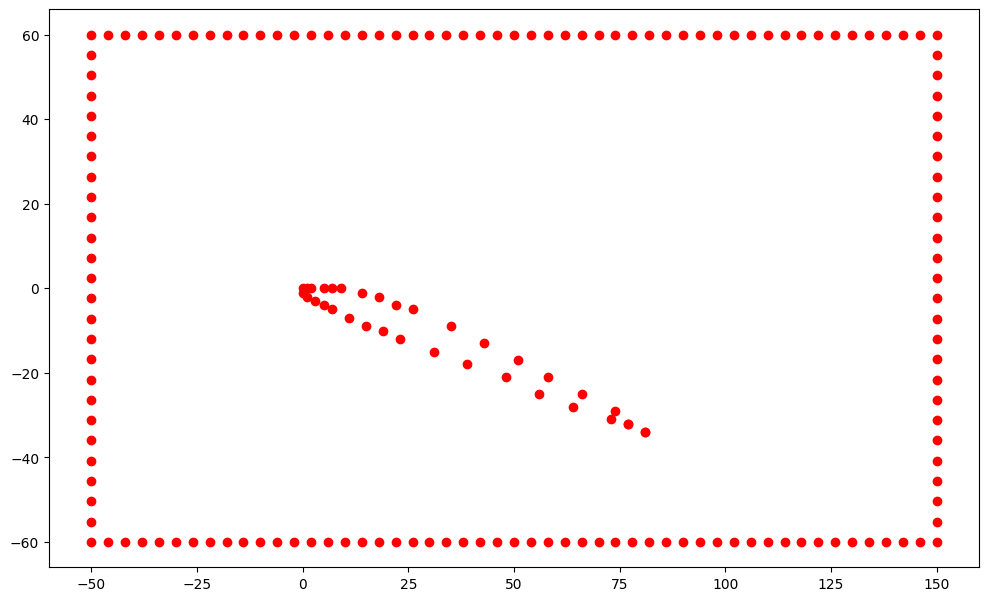

In [53]:
# Geometry
# Boundary Geometry
x_list1 = np.array([-50.,150.,150.,-50.,-50.])
y_list1 = np.array([-60.,-60.,60.,60.,-60])

# Airfoil Geometry
scale = 90 # Scaling of Airfoil for Faster Calculation
x_list2 = scale*np.array([1.00000, 0.95041, 0.90067, 0.80097, 0.70102, 0.60085,
                   0.50049, 0.40000, 0.29875, 0.24814, 0.19761, 0.14722,
                   0.09710, 0.07217, 0.04742, 0.02297, 0.01098, 0.00000,
                   0.01042, 0.02703, 0.05258, 0.07783, 0.10299, 0.15278,
                   0.20239, 0.25186, 0.30125, 0.40000, 0.49951, 0.59915,
                   0.69898, 0.79903, 0.89933, 0.94959, 1.00000, 1.00000,])[::-1]
y_list2 = scale*np.array([0.0, 0.00990, 0.01816, 0.03296, 0.04551, 0.05580,
                   0.06356, 0.06837, 0.06875, 0.06668, 0.06276, 0.05665,
                   0.04766, 0.04169, 0.03420, 0.02411, 0.01694, 0.00000,
                   -0.01448, -0.01927, -0.02482, -0.02809, -0.03016, -0.03227,
                   -0.03276, -0.03230, -0.03125, -0.02837, -0.02468, -0.02024,
                   -0.01551, -0.01074, -0.00594, -0.00352, -0.00105, -0.00105,])[::-1]

# Angle of Attack
alpha = 25 # In Degrees
DSR = np.pi/180 # deg to rad

# Rotational Matrix
rot = np.array([np.cos(alpha*DSR), -np.sin(alpha*DSR), np.sin(alpha*DSR), np.cos(alpha*DSR)]).reshape(2,2)

# Rotating X and Y variable of Airfoil
x_list2 = np.dot(np.c_[x_list2,y_list2],rot)[:,0]
y_list2 = np.dot(np.c_[x_list2,y_list2],rot)[:,1]

fig = plt.figure(figsize = (12,12),dpi =100)
plt.plot(x_list1,y_list1)
plt.plot(x_list2,y_list2,'r')

# Meshing
# Boundary - Segment List 
seg_list1 = np.array([50,25,50,25])
# Airfoil
Ns2 = x_list2.size-1
seg_list2 = np.ones(Ns2)

# Meshing By Boundary Element Method
x1,y1,xm1,ym1,xms1,yms1,nx1,ny1,l1,Ns1,seg_num1,lb1 = geometry(x_list1,y_list1,seg_list1)
x2,y2,xm2,ym2,xms2,yms2,nx2,ny2,l2,Ns2,seg_num2,lb2 = geometry(x_list2,y_list2,seg_list2)


# Combining the Values
x = np.append(x1[:-1],x2[:-1])
y = np.append(y1[:-1],y2[:-1])

xm = np.append(xm1,xm2)
ym = np.append(ym1,ym2)

l = np.append(l1,l2)

nx = np.append(nx1,nx2)
ny = np.append(ny1,ny2)

Ns = Ns1+Ns2

seg_list = np.append(seg_list1,seg_list2)
seg_num = np.zeros(seg_list.size)

for i in range(1,seg_list.size):
    seg_num[i] = seg_num[i-1]+seg_list[i-1]
    
fig = plt.figure(figsize=(12,12),dpi = 100)
fig.add_subplot(111,aspect = 'equal')
plt.scatter(x,y,c=u'r',marker=u'o')

Boundary Conditions

In [54]:
# Volumetric Flow rate
U = 0.5
Ns= int(Ns)

# Indices
inlet = 3
outlet = 1

# Type of Boundary Condition 
bct = np.ones(Ns) # Boundary type
bcv = np.zeros(Ns) # Boundary Condition Values

bcv[inlet] = -U/lb1[inlet]
bcv[outlet] = U/lb1[outlet]

# Setting the Boundary Condition for Each Element
BCT,BCV = setBC(bct,bcv,seg_list,seg_num)
    
F1,F2 = F1F2(xm,ym,x,y,l,nx,ny) # F1 and F2 at Midpoints
p,q = pqBC(F1, F2, BCT, BCV)

# Mesh Size
Nx = 15; Ny = 15;

X = np.linspace(x.min(),x.max(),Nx)
Y = np.linspace(y.min(),y.max(),Ny)
X,Y = np.meshgrid(X[1:-1],Y[1:-1])

X = X.ravel(); Y = Y.ravel()

# Removing Points Within Airfoil
D = np.zeros((X.size,xm2.size))
L = np.zeros((X.size,xm2.size))
I = []
for i in range(X.size):
    for j in range(xm2.size):
        D[i,j] = (X[i]-xm2[j])*nx2[j] + (Y[i]-ym2[j])*ny2[j]
        L[i,j] = np.sqrt((X[i] - xm2[j])**2 + (Y[i] - ym2[j])**2)
        
    if ((D[i,:]>0).all()):
        I.append(i)
    elif ((L[i,:]<1).any()):
        I.append(i)
        
X = np.delete(X.ravel(),I)
Y = np.delete(Y.ravel(),I)

# Calculating the u and v for the internal points (X,Y)
delta_x = delta_y = 0.01

F1, F2 = F1F2(X+delta_x,Y,x,y,l,nx,ny)
phi_x_plus = (np.dot(F2,p) - np.dot(F1,q))
F1, F2 = F1F2(X-delta_x,Y,x,y,l,nx,ny)
phi_x_minus = (np.dot(F2,p) - np.dot(F1,q))

F1, F2 = F1F2(X,Y+delta_y,x,y,l,nx,ny)
phi_y_plus = (np.dot(F2,p) - np.dot(F1,q))
F1, F2 = F1F2(X,Y-delta_y,x,y,l,nx,ny)
phi_y_minus = (np.dot(F2,p) - np.dot(F1,q))

# Centre Difference of Velocities
u = 0.5*(phi_x_plus - phi_x_minus)/delta_x
v = 0.5*(phi_y_plus - phi_y_minus)/delta_y

Post Processing

Text(0.5, 1.0, 'Potential flow over an Airfoil')

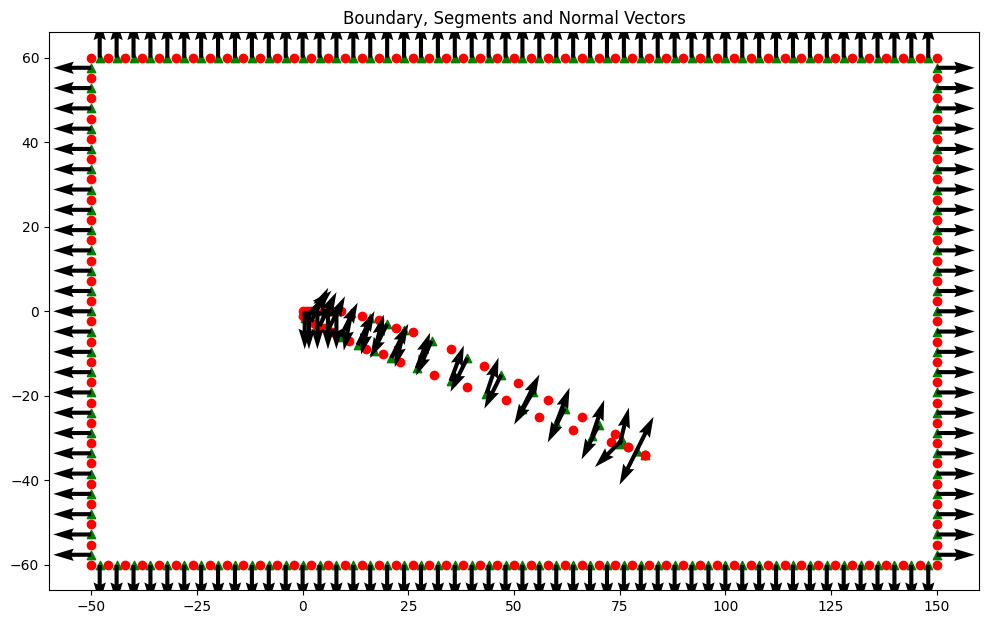

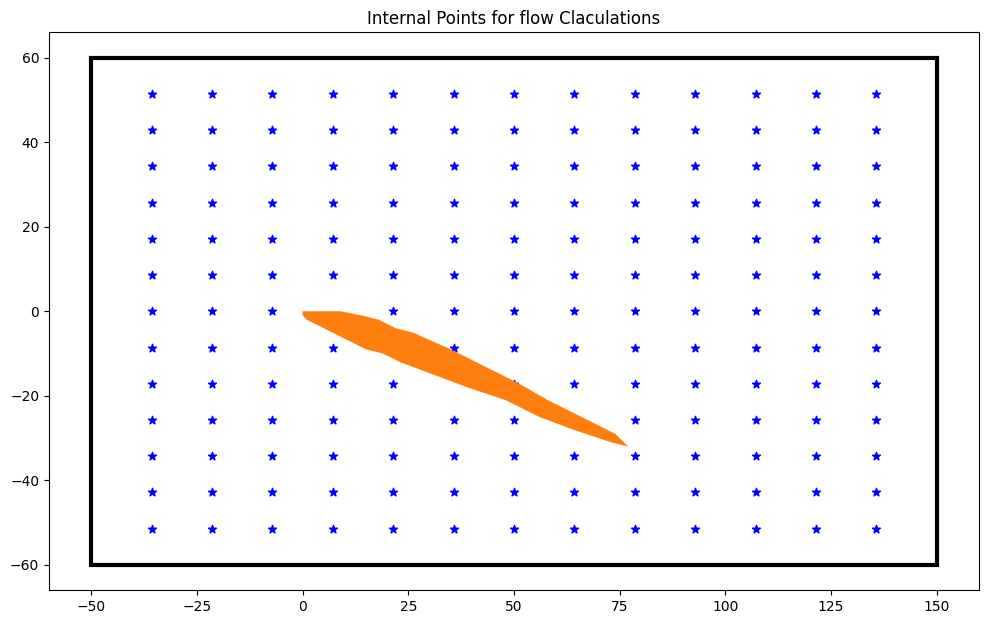

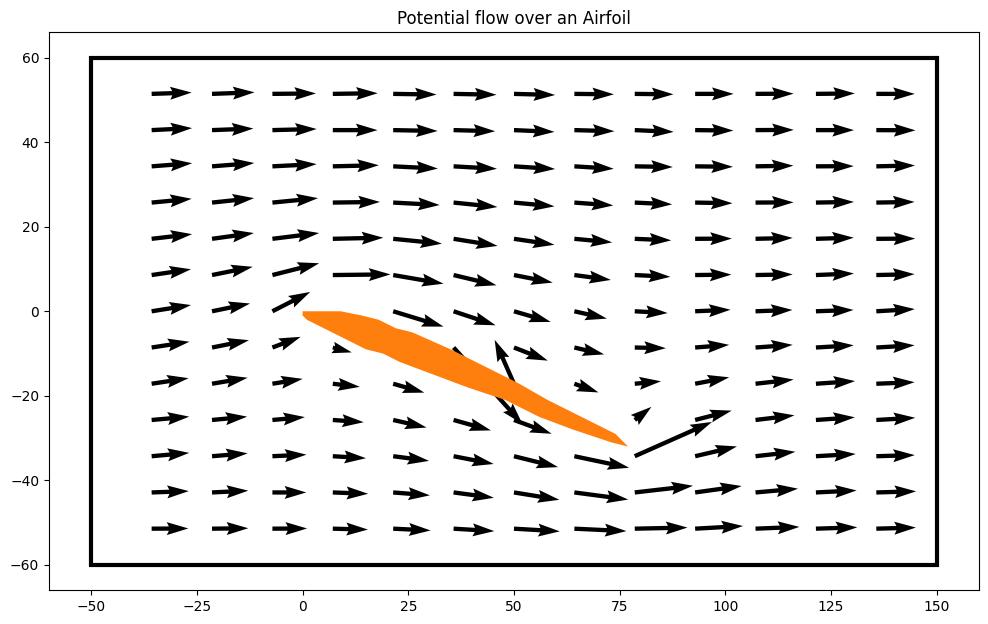

In [55]:
fig = plt.figure(figsize = (12,12), dpi= 100)
fig.add_subplot(111,aspect = 'equal')
plt.scatter(xm,ym,c=u'g',marker = u'^')
plt.scatter(x,y,c=u'r',marker = u'o')
plt.quiver(xm,ym,nx,ny)
plt.title('Boundary, Segments and Normal Vectors')

fig = plt.figure(figsize = (12,12), dpi= 100)
fig.add_subplot(111,aspect = 'equal')
plt.scatter(X,Y,c=u'b',marker = u'*')
plt.fill(x1,y1,fill = False,lw = 3)
plt.fill(x2,y2,fill = True,lw = 3)
plt.title('Internal Points for flow Claculations')

fig = plt.figure(figsize = (12,12), dpi= 100)
fig.add_subplot(111,aspect = 'equal')
plt.fill(x1,y1,fill = False,lw = 3)
plt.fill(x2,y2,fill = True,lw = 3)
plt.quiver(X,Y,u,v)
plt.title('Potential flow over an Airfoil')